> 在普通的感知机基础上，我们对感知机结构进行了延申，通过添加隐藏层的方式来使得感知机能够拟合非线性问题。这种包含隐藏层结构的感知机模型就是神经网络，也叫**多层感知机**(Multilayer Perceptron)。
![微信图片_20200520182853.jpg](https://img03.sogoucdn.com/app/a/100520146/3f887b437ba9d09a790f613aa0831125)
> 关于神经网络的众多概念和知识：包括**输入层、隐藏层、输出层、激活函数、前向传播、反向传播、梯度下降、权值更新**等
>
> [参考文章](https://mp.weixin.qq.com/s/f6qRBelaFrPxif4EDnlWbQ)

## 生成数据

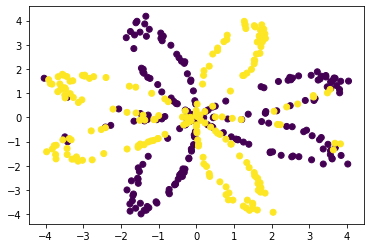

In [97]:
import matplotlib.pyplot as plt
import numpy as np


def create_dataset():
    np.random.seed(1)
    m = 400
    N, D = m >> 1, 2
    X, Y = np.zeros((m, D)), np.zeros((m, 1))
    a = m//100
    for i in range(D):
        ix = range(N*i, N*(i+1))
        t = np.linspace(i*3.12, (i+1)*3.16, N)+np.random.randn(N)*.2
        r = a*np.sin(4*t)+np.random.randn(N)*.2
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        Y[ix] = i
    return X, Y


X, Y = create_dataset()
X.shape, Y.shape
plt.scatter(X[:, 0], X[:, 1], c=Y[:])
plt.show()

## 网络结构的函数定义
> 假设X为神经网络的输入特征矩阵，y为标签向量。则含单隐层的神经网络的结构如下所示：
![微信图片_20200520194801.jpg](https://img02.sogoucdn.com/app/a/100520146/b11746f5a928ef440382e0720de84a2f)

In [98]:
def layer_sizes(X, Y):
    n_x = X.shape[1]  # 输入层大小
    n_y = Y.shape[1]  # 输出层大小
    return n_x, n_y

## 初始化模型参数
> 假设W1为输入层到隐层的权重数组、b1为输入层到隐层的偏置数组；W2为隐层到输出层的权重数组，b2为隐层到输出层的偏置数组。于是我们定义参数初始化函数如下：

In [99]:
def initialize_params(n_x, n_h, n_y):
    W1 = np.random.randn(n_x, n_h)*.01
    b1 = np.zeros((1, n_h))
    W2 = np.random.randn(n_h, n_y)*.01
    b2 = np.zeros((1, n_y))
    assert (W1.shape == (n_x, n_h))
    assert (b1.shape == (1, n_h))
    assert (W2.shape == (n_h, n_y))
    assert (b2.shape == (1, n_y))
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return params


n_x, n_y = layer_sizes(X, Y)
n_h = 4
params = initialize_params(n_x, n_h, n_y)
params

{'W1': array([[ 0.00814343,  0.0078047 , -0.01464054, -0.00154491],
        [-0.00092432, -0.00237875, -0.00755663,  0.01851438]]),
 'b1': array([[0., 0., 0., 0.]]),
 'W2': array([[ 0.00209097],
        [ 0.01555016],
        [-0.00569149],
        [-0.01061797]]),
 'b2': array([[0.]])}

In [100]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [101]:
p = np.random.randn(2, 3)
c = np.random.randn(2, 3)
p, p.sum(axis=0)

(array([[ 0.13224778, -0.5632366 ,  2.39014596],
        [ 0.24542285,  1.15259914, -0.22423577]]),
 array([0.37767063, 0.58936253, 2.16591019]))

## 前向传播
>  在定义好网络结构并初始化参数完成之后，就要开始执行神经网络的训练过程了。而训练的第一步则是执行前向传播计算。假设隐层的激活函数为tanh函数， 输出层的激活函数为sigmoid函数。则前向传播计算表示为：

In [102]:
def forward_propagation(X, params):
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]
    z1 = np.dot(X, W1)+b1
    A1 = np.tanh(z1)
    z2 = np.dot(A1, W2)+b2
    A2 = sigmoid(z2)
    assert (A2.shape == (X.shape[0], 1))
    cache = {
        "z1": z1,
        "A1": A1,
        "z2": z2,
        "A2": A2
    }
    return A2, cache


A2, cache = forward_propagation(X, params)
z1, A1, z2, A2 = cache.values()
z1.shape, A1.shape, z2.shape, A2.shape

((400, 4), (400, 4), (400, 1), (400, 1))

## 计算当前训练损失
![微信图片_20200520195152.jpg](https://img03.sogoucdn.com/app/a/100520146/9fb557c912f374dd85b916642b0a3a22)

In [103]:
def compute_cost(A2, Y):
    m = Y.shape[0]
    cost = -(A2*Y+(1-A2)*(1-Y)).sum()*(-1/m)
    assert(isinstance(cost, float))
    return cost


compute_cost(A2, Y)

0.4999752629386272

## 执行反向传播
> 当前向传播和当前损失确定之后，就需要继续执行反向传播过程来调整权值了。中间涉及到各个参数的梯度计算，具体如下图所示(来自Andrew NG deeplearningai深度学习系列课程第一门课的assignment3，左边导数相同，右边代码和我自己有些不同)
![微信图片_20200520195553.jpg](https://img01.sogoucdn.com/app/a/100520146/063f4f2bcc1a18a01e64522e1a2be617)

In [104]:
def backward_propagation(params, cache, X, Y):
    m = X.shape[0]
    W1, W2 = params["W1"], params["W2"]
    A1, A2 = cache["A1"], cache["A2"]
    dz2 = A2-Y
    dW2 = np.dot(A1.T, dz2)/m
    db2 = np.sum(dz2, axis=0, keepdims=True)/m
    dz1 = np.dot(dz2, W2.T)*(1-np.power(A1, 2))
    dW1 = np.dot(X.T, dz1)/m
    db1 = np.sum(dz1, axis=0, keepdims=True)/m
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    return grads


grads = backward_propagation(params, cache, X, Y)
dW1, db1, dW2, db2 = grads.values()
dW1.shape, db1.shape, dW2.shape, db2.shape

((2, 4), (1, 4), (4, 1), (1, 1))

## 权值更新
$$u=u-a\frac{\partial J}{\partial u}$$

In [105]:
def update_params(params, grads, lr=.1):
    W1, b1, W2, b2 = params.values()
    dW1, db1, dW2, db2 = grads.values()
    W1 -= lr*dW1
    b1 -= lr*db1
    W2 -= lr*dW2
    b2 -= lr*db2
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return params

## 训练

In [106]:
def nn_model(X, Y, h, num_iterations=10000, print_cost=False):
    n_x, n_y = layer_sizes(X, Y)
    n_h = h
    params = initialize_params(n_x, n_h, n_y)
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, params)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(params, cache, X, Y)
        params = update_params(params, grads, .1)
        if print_cost and (i % 1000) == 0:
            print(f"After {i} iters ,cost: {cost}")
    return params


params = nn_model(X, Y, 4, print_cost=True)
A2 = forward_propagation(X, params)

After 0 iters ,cost: 0.4999972321281325
After 1000 iters ,cost: 0.5929779512653712
After 2000 iters ,cost: 0.7453493865853775
After 3000 iters ,cost: 0.7670416995857511
After 4000 iters ,cost: 0.7767982054602545
After 5000 iters ,cost: 0.7828578788137446
After 6000 iters ,cost: 0.7871774605355009
After 7000 iters ,cost: 0.7905024302865933
After 8000 iters ,cost: 0.7931901347804413
After 9000 iters ,cost: 0.7954373054522554


### 模型主体完成之后也可以再定义一个基于训练结果的预测函数：

In [107]:
def predict(X, params):
    A2, cache = forward_propagation(X, params)
    return (A2 > .5)


preds = predict(X, params)

### 测试预测准确率：

In [108]:
def accuaracy(preds, Y):
    return float((np.dot(preds.T, Y)+np.dot(1-preds.T, 1-Y))/Y.size)*100

In [109]:
x_min, x_max = 0.1, 1
y_min, y_max = .2, 2.3
h = .1
d1 = np.arange(x_min, x_max, h)
d2 = np.arange(y_min, y_max, h)
xx, yy = np.meshgrid(d1, d2)
# d1,d2.shape ,xx.shape,yy.shape
xx.shape, yy.shape, xx, yy

((21, 9),
 (21, 9),
 array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0

### 训练实现

In [110]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    h = .01
    d1, d2 = np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)
    xx, yy = np.meshgrid(d1, d2)
    Z = model(np.c_[xx.flatten(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z,)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.scatter(X[:, 0], X[:, 1], c=y)

Accuracy for 1 hidden units: 64.5 %
Accuracy for 2 hidden units: 62.0 %
Accuracy for 3 hidden units: 87.25 %
Accuracy for 4 hidden units: 86.75 %
Accuracy for 5 hidden units: 87.5 %
Accuracy for 10 hidden units: 87.25 %
Accuracy for 20 hidden units: 87.25 %


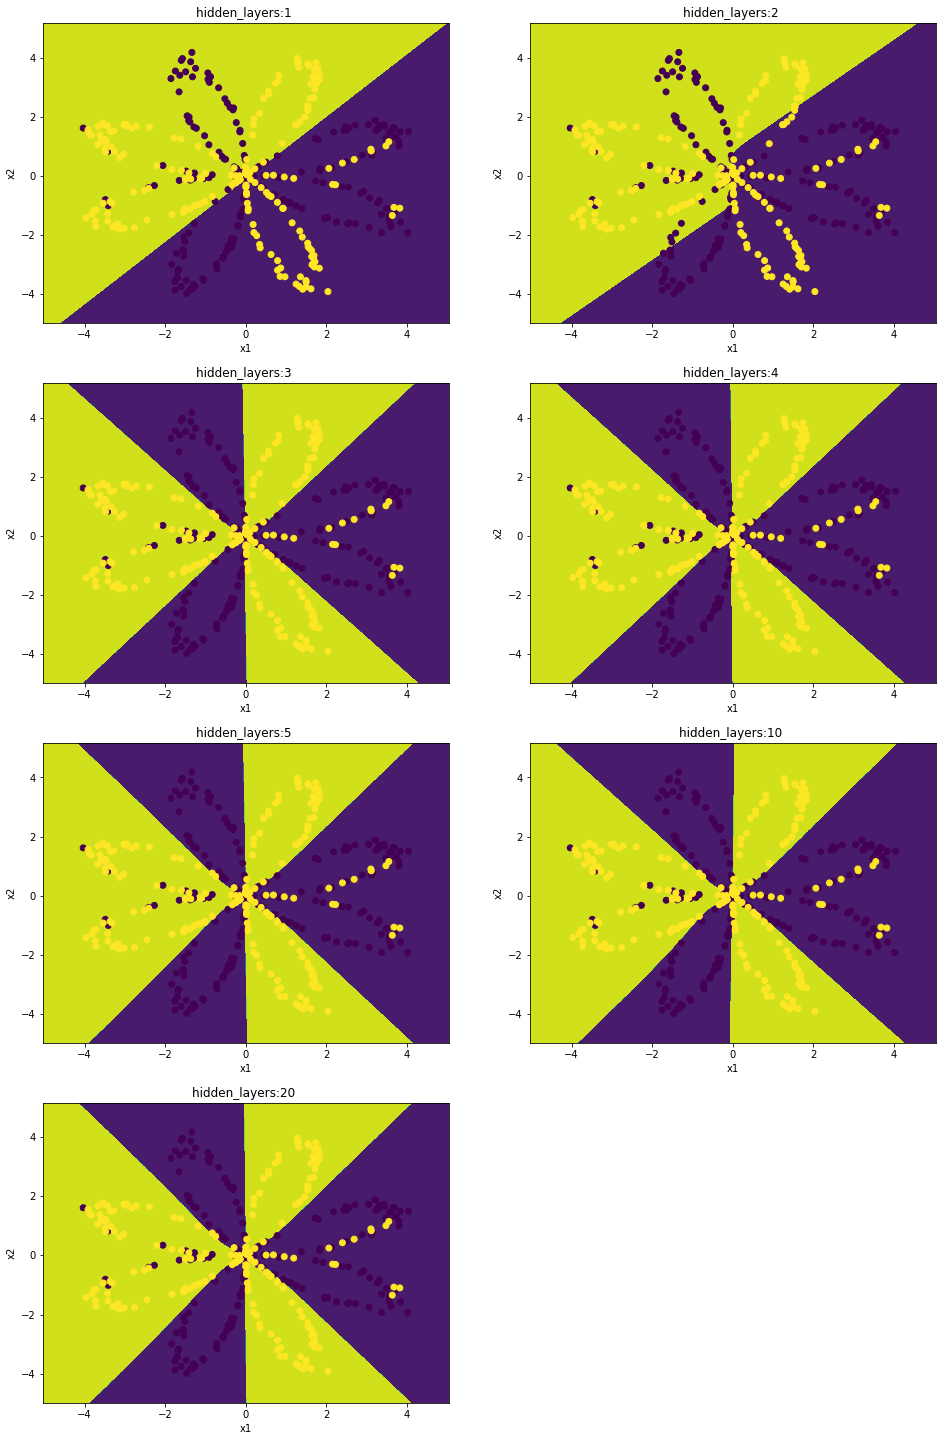

In [111]:
plt.figure(figsize=(16, 32))
hidden_layers = [1, 2, 3, 4, 5, 10, 20]
for i, n_layer in enumerate(hidden_layers):
    plt.subplot(5, 2, i+1)
    plt.title(f"hidden_layers:{n_layer} ")
    params = nn_model(X, Y, h=n_layer, print_cost=False)
    plot_decision_boundary(lambda x: predict(x, params), X, Y)
    preds = predict(X, params)
    acc = accuaracy(preds, Y)
    print(f"Accuracy for {n_layer} hidden units: {acc} %")